In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
from preprocessing import initiation, quality_check, cleaning_the_soup

In [2]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

***
# Single-cell RNA sequencing data analysis of primary tumor from a breast cancer patient
***

Presented by: Sunaina (Intern)

# Background for why we are interested in scRNAseq:


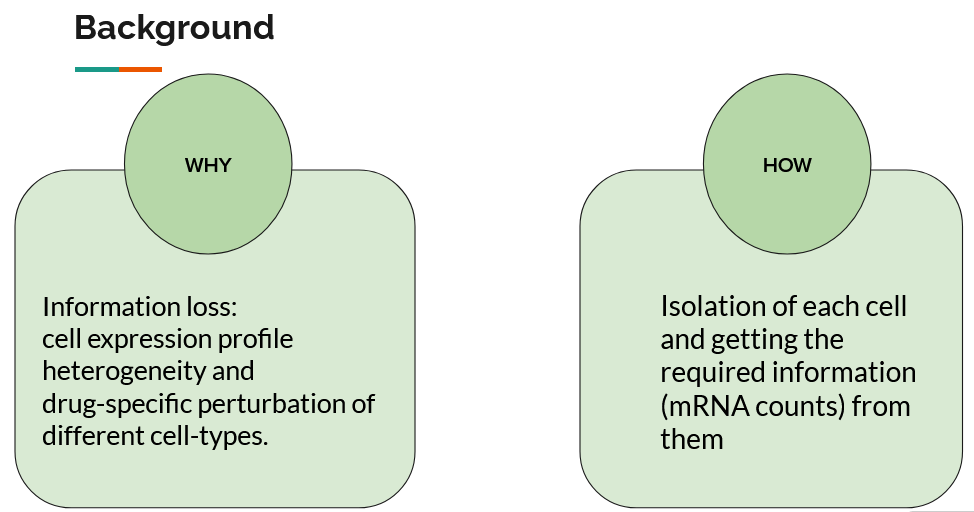
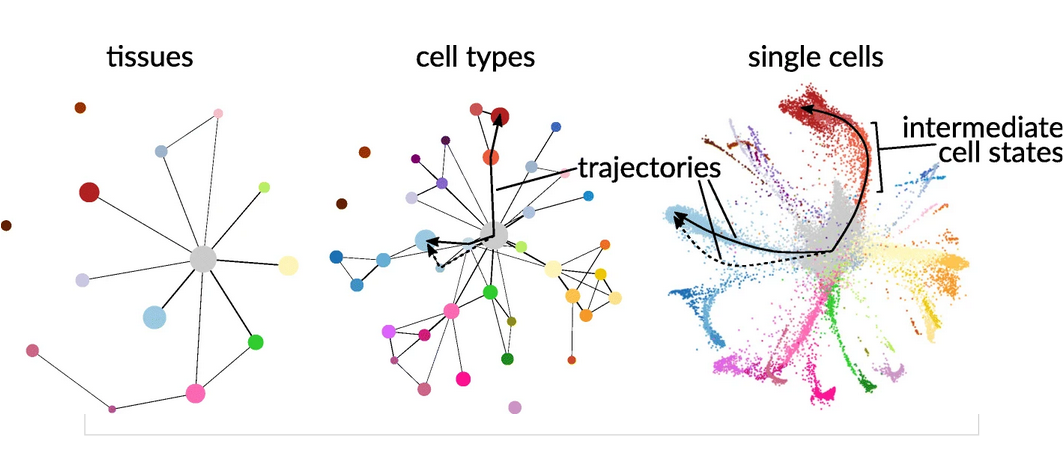

#### General issues in the analysis: 

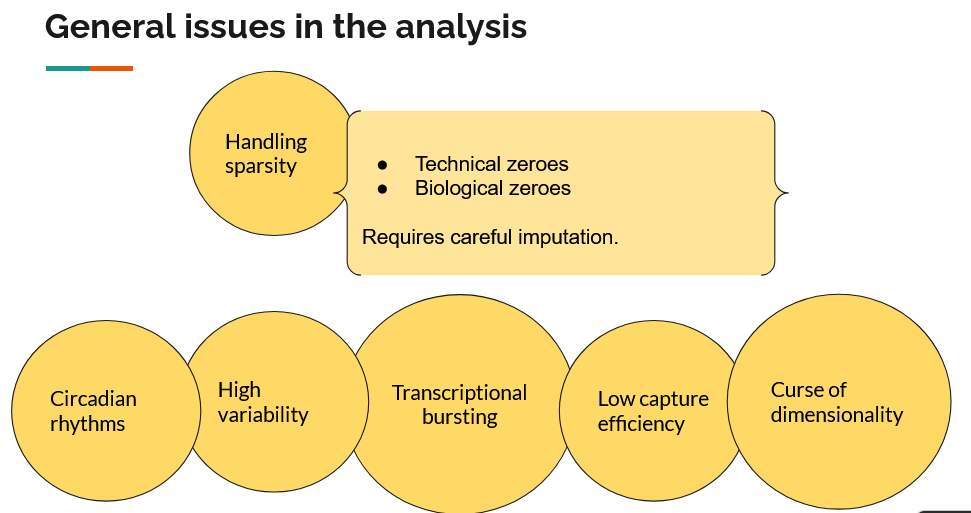

In [ ]:
%%R
x <- "test-check for R"
x

For different samples, intitiate them as annData objects using soupXcounts_per_sample.ipynb, normalize them and save them as their own .h5ad objects.

In [3]:
import anndata

In [4]:
lymph_3 = anndata.read_h5ad("/home/digemed/Sunaina-single-cell/GSE225600/h5ad samples/SRR23525752_GSM7050930_PT_3_lymph_node_sc_S3_normalized.h5ad")
lymph_2 = anndata.read_h5ad("/home/digemed/Sunaina-single-cell/GSE225600/h5ad samples/SRR23525752_GSM7050930_PT_2_lymph_node_S2_normalized.h5ad")
lymph_1 = anndata.read_h5ad("/home/digemed/Sunaina-single-cell/GSE225600/h5ad samples/SRR23525752_GSM7050930_PT_7_lymph_node_S7_normalized.h5ad")

primary_1 = anndata.read_h5ad("/home/digemed/Sunaina-single-cell/GSE225600/h5ad samples/SRR23525754_GSM7050928_PT_7_tumor_sc_S7_normalized.h5ad")
primary_2 = anndata.read_h5ad("/home/digemed/Sunaina-single-cell/GSE225600/h5ad samples/SRR23525757_GSM7050925_PT_2_tumor_sc_S2_normalized.h5ad")
primary_3 = anndata.read_h5ad("/home/digemed/Sunaina-single-cell/GSE225600/h5ad samples/SRR23525756_GSM7050926_PT_3_tumor_sc_S3_normalized.h5ad")

In [5]:
lymph_1.var_names_make_unique()
lymph_2.var_names_make_unique()
lymph_3.var_names_make_unique()
primary_1.var_names_make_unique()
primary_2.var_names_make_unique()
primary_3.var_names_make_unique()

In [6]:
lymph_1.obs['sample'] = "Lymph_1"
lymph_2.obs['sample'] = "Lymph_2"
lymph_3.obs['sample'] = "Lymph_3"

primary_1.obs["sample"] = "Primary_1"
primary_2.obs["sample"] = "Primary_2"
primary_3.obs["sample"] = "Primary_3"

In [ ]:
lymph_adata = lymph_1.concatenate(lymph_2, lymph_3)

In [7]:
primary_adata = primary_1.concatenate(primary_2, primary_3)

/home/digemed/Sunaina-single-cell/Project/Project/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


### Choose adata to be either primary or lymph. These two objects are usually huge (2-3 GB each) so it is not recommended to concatenate them. If they are concatenated, just re-run the cell if it can't allocate memory to the object. 

In [8]:
adata = primary_adata

In [ ]:
adata.to_df()

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

from matplotlib import pyplot as plt

with plt.rc_context():  # Use this to set figure params like size and dpi
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'sample', rotation= 45, show=False)
    plt.savefig("QC1_all_samples.png",dpi=300, bbox_inches="tight")
    sc.pl.violin(adata, ['pct_counts_mt'],
             jitter=0.4, groupby = 'sample', rotation= 45, show=False)
    plt.savefig("QC2_all_samples.png",dpi=300, bbox_inches="tight") 
    sc.pl.violin(adata, ['pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample', rotation= 45, show=False)
    plt.savefig("QC3_all_samples.png",dpi=300, bbox_inches="tight")

Quality check of the cellular covariates:
- n_genes_by_counts in .obs is the number of genes with positive counts in a cell,

- total_counts is the total number of counts for a cell, this might also be known as library size, and

- pct_counts_mt is the proportion of total counts for a cell which are mitochondrial.


In [ ]:
import rpy2
print(rpy2.__version__)

In [ ]:
%%R

# Make sure the Matrix package has the most recent version and it should be loaded before the other packages. Otherwise, it gives an error since the
# packages re-install a lower version of Matrix

# install.packages("Matrix")
library("Matrix")
packageVersion("Matrix")


In [ ]:
%%R
# install.packages("Seurat")
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("scater")
# BiocManager::install("scDblFinder")

# install.packages("BiocParallel")

library("Seurat")
library("scater")
library("scDblFinder")
library("BiocParallel")

In [ ]:
data_mat = adata.X.T
data_mat

### Finding doublets in the dataset

It is entirely possible for a single droplet to contain two cells with one barcode bead. In that case, the mRNA counts associated with each bead will be the average of the two cells. This will distort the further downstream analysis. Thus, they need to be removed. The scDblFinder package solves this problem by creating artificial doublet droplet and comparing their expression profile with the real droplets present. This produces a score for each cell and classifies the cells based on this score.

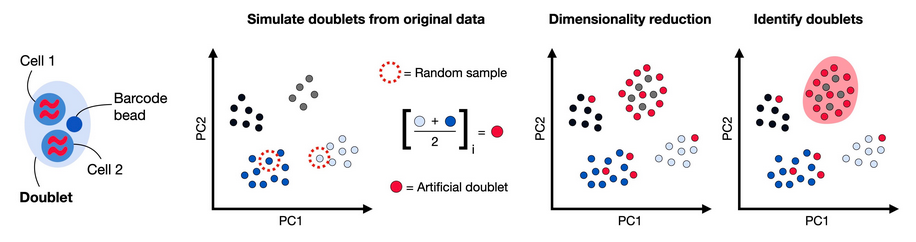

In [ ]:
%%R -i data_mat -o doublet_score -o doublet_class

# doublet_class refers to whether it's a single or doublet, this classification is based on averaging two random cells, creating "artificial" doublets and comparing gene expression between these and other cells

sce <- scDblFinder(SingleCellExperiment(list(counts=data_mat),))
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

In [ ]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class

adata.obs.scDblFinder_class.value_counts()

### Log-shift transformation

Highly expressed genes have more variance in their distribution as compared to lowly expressed genes. Due to this difference in variance between different genes among different cells or *heteroskedasticity*, one cannot use standard statistical tools that assume same variance among different variables. To treat this, there are different methods. 

1. Log-shift transformation: 
            $f(y) = \log{}(\frac{y}{s} + y_0)$

where y are the raw counts, $y_0$ is pseudocount that is added such that we don't have to take log of zero and s is a size factor that can be estimated using : 
            $$s = \frac {\sum {y_{g,c}}}{L}$$
            
L can either be median gene counts or $10^6$ to be converted to counts per million (CPM).

In [10]:
import seaborn as sns

Before log-transformation: Cell_0-0         2421.0
Cell_1-0         7747.0
Cell_2-0         8945.0
Cell_3-0         8701.0
Cell_4-0         1023.0
                 ...   
Cell_16985-2     2801.0
Cell_16990-2    23968.0
Cell_16997-2     2586.0
Cell_16998-2     1737.0
Cell_17001-2     2643.0
Name: total_counts, Length: 22050, dtype: float32
After log-shift transformation :Cell_0-0        1049.292193
Cell_1-0        1209.132597
Cell_2-0        1138.200328
Cell_3-0        1196.482665
Cell_4-0         905.074497
                   ...     
Cell_16985-2    1080.804556
Cell_16990-2    1390.844738
Cell_16997-2    1194.207711
Cell_16998-2     934.373050
Cell_17001-2    1146.640793
Length: 22050, dtype: float64


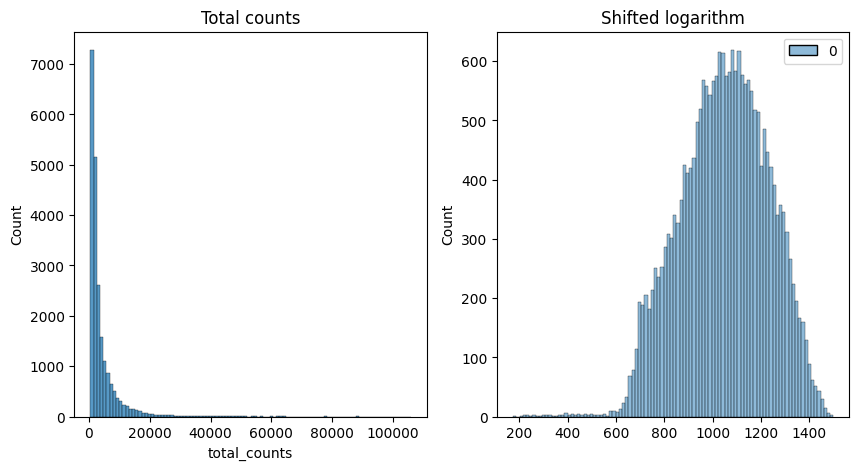

In [11]:
# before normalization 
import matplotlib.pyplot as plt

scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
print(f"Before log-transformation: " + str(adata.obs["total_counts"]))

print("After log-shift transformation :" + str(adata.to_df(layer = "log1p_norm").sum(axis=1)))

p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

2. Analytic Pearson residuals :

The raw counts are being fit to a negative binomial regression.
Pearson's residuals are calculated from that to generate estimates for technical noise. Residuals refer to the difference between the actual and predicted values. Here, s.d. of a binomial distribution is estimated. Pearson's residuals are calculated as: 
                       $$r = \frac{y_{observed} - y_{predicted}}{\sigma} $$
Comparison between different transformations showed that this method removed sampling noise.

Both positive and negative values are present in the output. For positive values, the more counts are observed than expected compared to the gene's expression. And vice versa. 

### Calculating Pearson's residuals with the full dataset takes up a lot of memory and Jupyter notebook usually crashes.

In [ ]:
from scipy.sparse import csr_matrix

adata.layers["analytic_pearson_residuals"] = csr_matrix(sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)["X"]) # keep inplace at False since you don't want to add the transformation to the actual data
print("After Pearson transformation: " + str(adata.to_df(layer = "analytic_pearson_residuals").sum(1)))

sns.histplot(adata.layers["analytic_pearson_residuals"].sum(axis=1), bins=100, kde=False)
plt.show()

## 6. Feature selection

1. Highly variable genes: Since scRNA-seq data is concentrated with dropouts (that is -- has too many zeroes since gene expression profile from EACH cell is calculated), informative features (genes) need to be selected. This can be performed by calculating the coefficient of variance for each gene along all the cells : $$ CV = \frac{\sigma}{\mu}$$

or the dispersion: $$ Dispersion = \frac{\sigma^2}{\mu} $$


With the default value of flavor = "Seurat", scanpy outputs the list of highly variable genes by calculating dispersion for each gene and then ranking using dispersion. But these methods expect logarithmized data which may be biased since we are adding arbitrary pseudo-counts to the $\frac{y}{c}$ term as we have observed before. Unclear on how to find highly variable genes for pearson's residuals, using the pre-made functions doesn't really give the appropriate plots.

For log-shift transformation: 


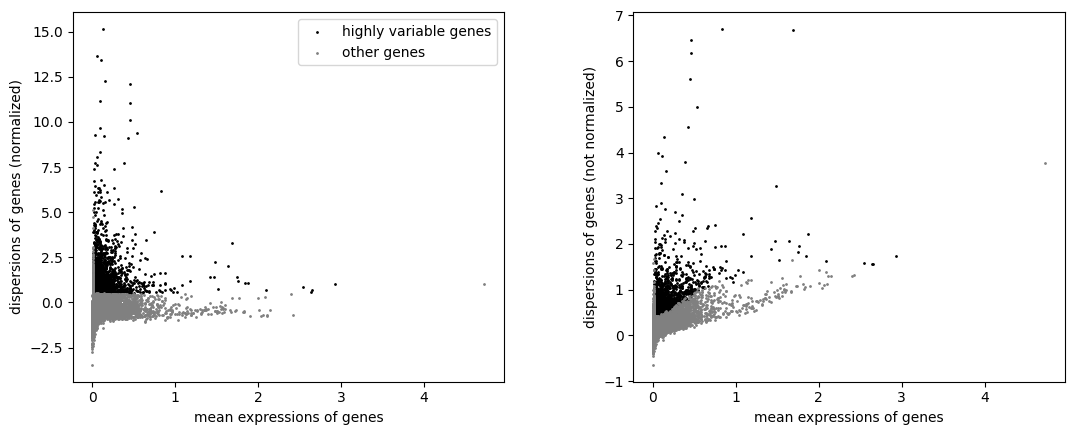

Highly variable genes: 2266


In [12]:
sc.pp.highly_variable_genes(adata, layer="log1p_norm", batch_key="sample")
print("For log-shift transformation: ")
sc.pl.highly_variable_genes(adata)

# sc.pp.highly_variable_genes(adata, layer="analytic_pearson_residuals")
# print("For analytic pearson residuals: ")
# sc.pl.highly_variable_genes(adata)


# adata.write(in_dir + "S3_adata_normalization.h5ad")

variable_genes = adata.var.highly_variable
print("Highly variable genes: %d"%sum(variable_genes))


In [13]:
sc.pp.highly_variable_genes(
    primary_adata, n_top_genes=4000, flavor="cell_ranger", batch_key="sample"
)
adata_hvg = primary_adata[:, primary_adata.var["highly_variable"]].copy()

adata_hvg

AnnData object with n_obs × n_vars = 22050 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_haemoglobin', 'log1p_total_counts_haemoglobin', 'pct_counts_haemoglobin', 'scDblFinder_score', 'scDblFinder_class', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'haemoglobin', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mea

### Feature selection

2. Using deviance: A "null-model" is used to approximate the expression profiles of genes which are constant for different cells. Then, the genes having a high variability will have a higher "deviance". This is again based upon negative binomial distribution assumptions. In fact, deviance residuals are similar to Pearson's residuals.

In [ ]:
%%R

# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("scry")
library("scry")

<span style='color:Cyan'> The next cell will have to be re-run if it gives error on the first run. This is due to the initialisation of the annData object. Since these data objects are very huge (2-3 GB at times), it takes a lot of memory to load them up. When using rpy2, at times, it seemingly breaks up if the size is large. To prevent this, just re-run the cell. Since Jupyter notebook saves the previous outputs, this speeds up the process and it is able to load the whole object. When the anndata object exceeds the size of 3-4 GB, the rpy2 crosstalk between Python and R becomes really slow and Jupyter kernel crashes. This problem only exists in R-based tools. At best, it might also take a lot of time to generate annData with both primary and lymph samples. </span>

In [ ]:
#Converting the python annData object directly to R's since it directly works with raw counts
# adata = sc.read(filename="adata_normalization.h5ad")
ro.globalenv["adata"] = adata

In [ ]:
%%R 
sce = devianceFeatureSelection(adata, assay="X")

In [ ]:
# Converting the R object to python again

deviance = ro.r("rowData(sce)$binomial_deviance").T
adata.var["deviance"] = deviance

top_4000 = adata.var["deviance"].sort_values(ascending=False)

# adata.var["highly_deviant"] = mask

adata_top_4000 = adata[:, list(top_4000.index)]
# arbitarily taking the top 4000 number of genes 
adata_top_4000

### Dimensionality Reduction

1. PCA: For single cell RNA seq analysis, PCA is not used for dimensionality reduction but for the selection of Principal components that are used for downsream analysis. We take the highly deviant genes and plot the PCA plot of that. Make sure the data is properly normalized and log shift transformation is used BEFORE doing the PCA. Since the raw counts have dropouts, the raw count PCA is not meaningful and does not show clusters based on cell types.

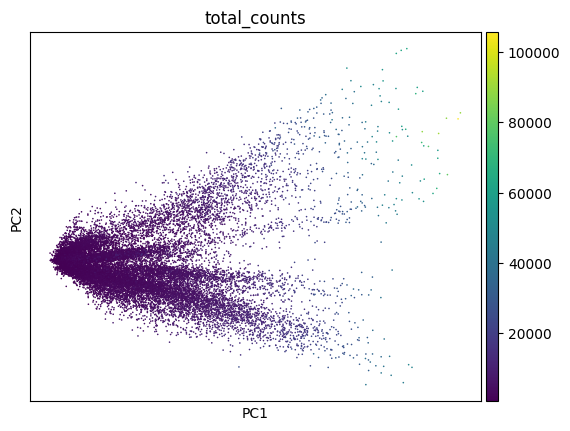

In [14]:
# sc.pp.normalize_total(primary_adata, target_sum=1e4)
sc.pp.log1p(primary_adata)
sc.pp.pca(primary_adata)
sc.pl.pca(primary_adata, color="total_counts")

/home/digemed/Sunaina-single-cell/Project/Project/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


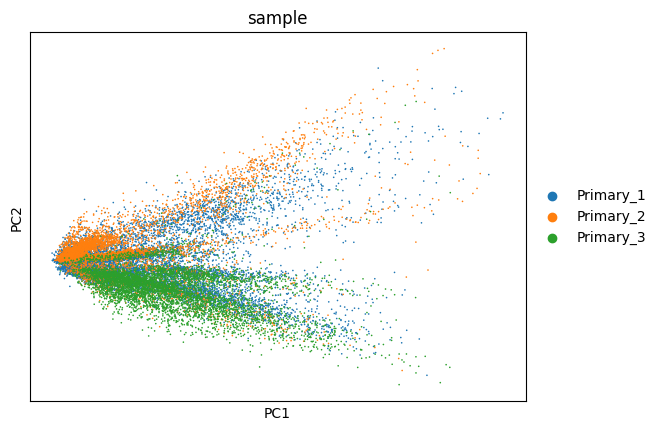

In [15]:

sc.tl.pca(primary_adata)
sc.pl.pca(primary_adata, color="sample")

### Dimensionality reduction:

2. t-SNE: t refers to t-distribution used. t-SNE is a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components. The method defines a Gaussian probability distribution based on the high-dimensional Euclidean distances between data points. Subsequently, a Student t-distribution is used to recreate the probability distribution in a low dimensional space.

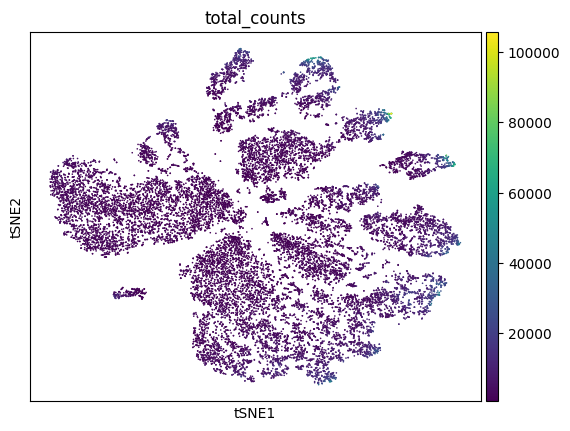

In [16]:
sc.tl.tsne(adata)
sc.pl.tsne(adata, color= "total_counts")

/home/digemed/Sunaina-single-cell/Project/Project/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


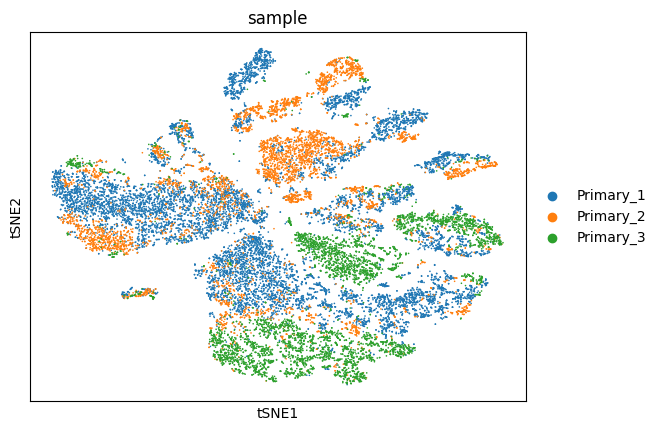

In [17]:
sc.pl.tsne(adata, color= "sample")

3. UMAP: UMAP is a graph based, non-linear dimensionality technique and principally similar to t-SNE. It constructs a high dimensional graph representation of the dataset and optimizes the low-dimensional graph representation to be structurally as similar as possible to the original graph. PCA pre-processing is used to compute the number of neighbors for the initial high dimensional graph. May not always get clustering especially if cellular differences are not present. PCA is produced even before UMAP to reduce the high dimensions.

*neighbors* produces a kNN based lower dimensional graph using dimensionally-reduced dataset. 

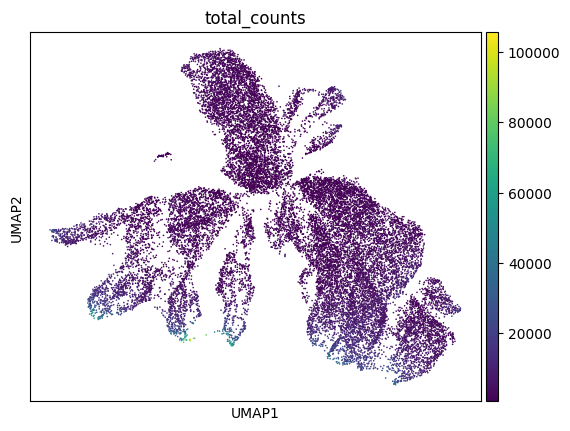

In [18]:
sc.pp.neighbors(primary_adata
                ) 
sc.tl.umap(primary_adata)
sc.pl.umap(primary_adata, color="total_counts")      
# print(adata_top_4000)

/home/digemed/Sunaina-single-cell/Project/Project/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


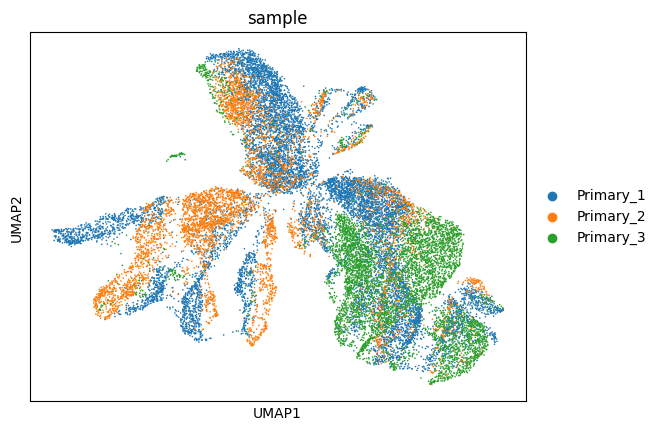

In [19]:
sc.pl.umap(primary_adata, color="sample")  

### Identification of cellular structures in the scRNA-seq dataset:

Even though we can see certain clusters in the pre-processing steps of our dataset, they have not been distincly separated into actual clusters. Rather than relying on intuition or visual maps, since we are dealing with around 4000 genes for each cell, there are community-detection algorithms for the evaluation of clusters. One of the popular approaches is using the Leiden algorithm. A high-level depiction of the algorithm is provided:

1. Each node (cell) starts as its own cluster.
2. These nodes go through a local moving process where nodes move to optimise a "quality function" such as modularity of the network to measure the connectedness of the various nodes.
3. Then the partitions formed through these nodes produce a cluster-map which further undergoes a refining process where nodes which increase the modularity of ANY community (notice the ANY. It's not the community with highest modularity -- more like it's ANY community that is randomly chosen that increases the modularity function), these nodes are joined with those communities
4. Further the different nodes are aggregated under each of the clusters while still maintaining an optimum level of modularity

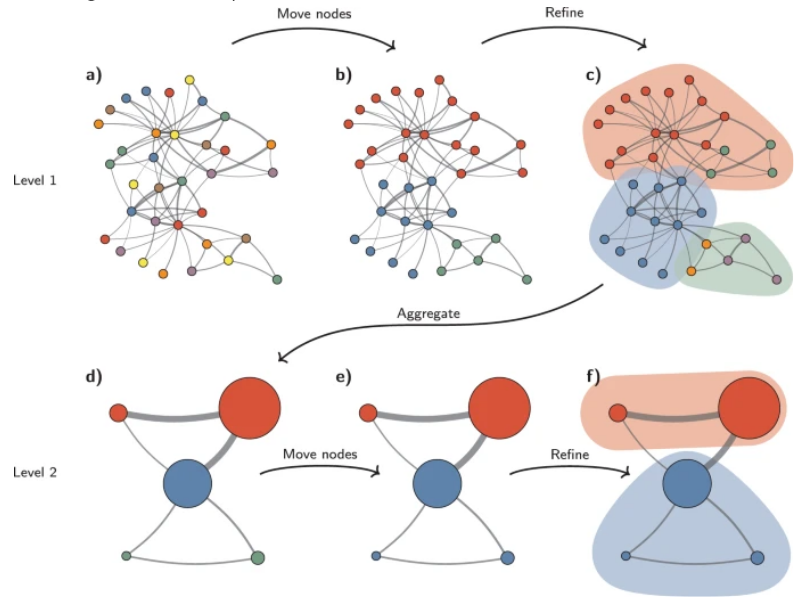

/home/digemed/Sunaina-single-cell/Project/Project/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


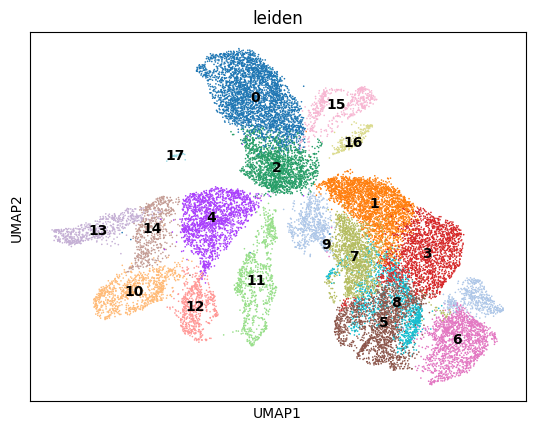

In [20]:
sc.tl.leiden(primary_adata, key_added="leiden", resolution = 0.6)
sc.pl.umap(
    primary_adata,
    color=["leiden"],
    legend_loc="on data",
)

Resolution is a highly important parameter of the clustering algorithm. With higher resolution, more clusters/"communities" are detected.

/home/digemed/Sunaina-single-cell/Project/Project/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/digemed/Sunaina-single-cell/Project/Project/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/digemed/Sunaina-single-cell/Project/Project/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


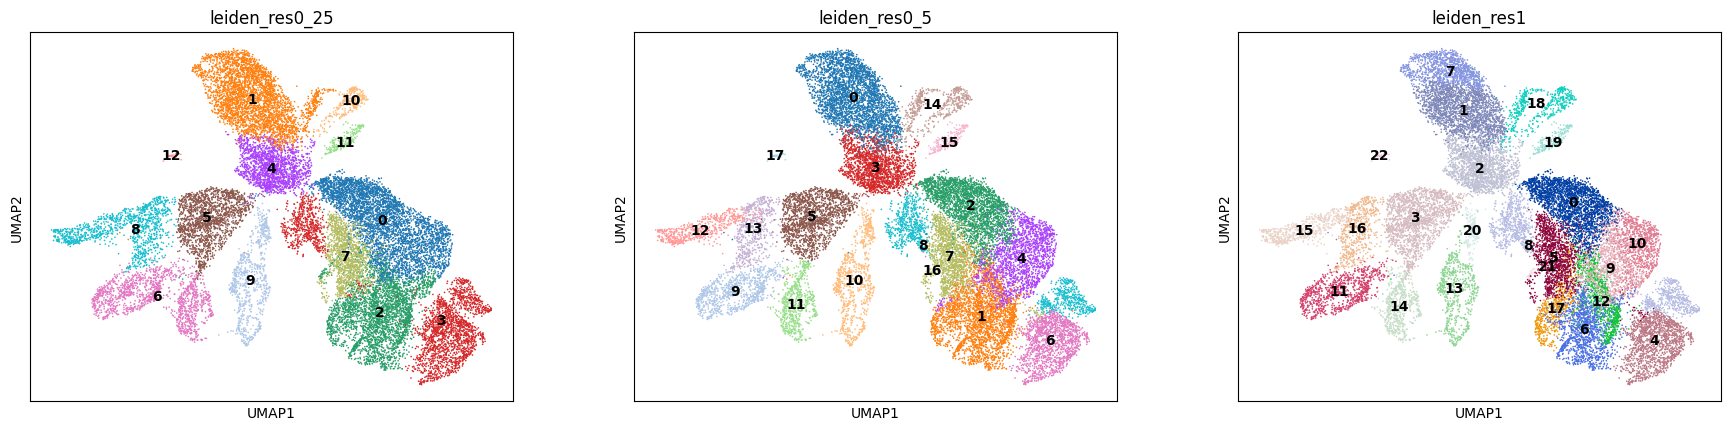

In [21]:
sc.tl.leiden(primary_adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(primary_adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(primary_adata, key_added="leiden_res1", resolution=1.0)
sc.pl.umap(
    primary_adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

In [ ]:
adata_hvg.write( "/home/digemed/Sunaina-single-cell/GSE225600/h5ad samples/" + "primary_adata_variable_genes.h5ad")
primary_adata